In [3]:
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [4]:
!pip install h2o

     |████████████████████████████████| 164.8MB 60kB/s 
  Created wheel for h2o: filename=h2o-3.32.1.2-py2.py3-none-any.whl size=164848811 sha256=e87ec641062f2b9fb819d8ce894182cf7480f61b432918e4ed2e80620698d9a5
  Stored in directory: /root/.cache/pip/wheels/37/b6/c7/c1cfdcd471d476b2b5129f4d27a0fd89043858ee74eda7ee7a
Successfully built h2o


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML

In [6]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpszbpwla5
  JVM stdout: /tmp/tmpszbpwla5/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpszbpwla5/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_unknownUser_h8e8sb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
df = pd.read_csv('https://github.com/srivatsan88/YouTubeLI/blob/master/dataset/consumer_compliants.zip?raw=true',compression='zip',sep=",", quotechar = '"')

In [9]:
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,This auto loan was opened on XX/XX/2020 in XXX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,In XXXX of 2019 I noticed a debt for {$620.00}...,None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX an...",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in...",None,CAPITAL ONE FINANCIAL CORPORATION,CA,None,None,Consent provided,Web,3/6/2020,Closed with explanation,Yes,NaN,3556237
4,2/14/2020,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,This debt was incurred due to medical malpract...,Company believes it acted appropriately as aut...,"Merchants and Professional Bureau, Inc.",OH,432XX,None,Consent provided,Web,2/14/2020,Closed with explanation,Yes,NaN,3531704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57448,2/29/2020,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,I am attempting to make a payment toward my st...,None,"Nelnet, Inc.",KS,None,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549178
57449,2/11/2020,Debt collection,Other debt,Attempts to collect debt not owed,Debt was paid,Received letter for {$480.00}. Original credit...,Company has responded to the consumer and the ...,"The Receivable Management Services LLC, New Yo...",AZ,853XX,None,Consent provided,Web,2/18/2020,Closed with explanation,Yes,NaN,3527928
57450,2/29/2020,Debt collection,Other debt,Communication tactics,"Used obscene, profane, or other abusive language",entire time 10 years until XX/XX/2020. XXXX ma...,Company has responded to the consumer and the ...,"Convergent Resources, Inc.",NJ,8101,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549238
57451,1/16/2020,Checking or savings account,Checking account,Problem with a lender or other company chargin...,Transaction was not authorized,I am a customer with Wells Fargo Bank. Recentl...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,AZ,852XX,None,Consent provided,Web,1/22/2020,Closed with explanation,Yes,NaN,3498566


In [10]:
df['Product'].value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                        9799
Checking or savings account     7003
Student loan                    2950
Vehicle loan or lease           2736
Name: Product, dtype: int64

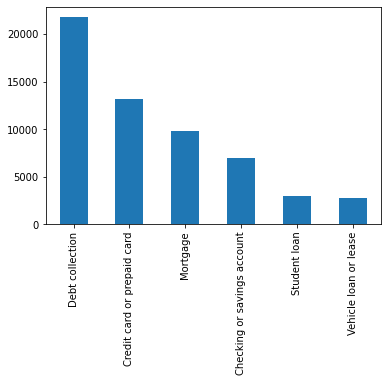

In [11]:
 df['Product'].value_counts().plot(kind='bar')

In [12]:
df['Company'].value_counts()

CITIBANK, N.A.                              3226
CAPITAL ONE FINANCIAL CORPORATION           2711
BANK OF AMERICA, NATIONAL ASSOCIATION       2580
JPMORGAN CHASE & CO.                        2409
WELLS FARGO & COMPANY                       2001
                                            ... 
Collection Associates, Ltd.                    1
Celentano, Stadtmauer & Walentowicz, LLP       1
General Mortgage Capital Corporation           1
Fig Tech Inc.                                  1
High Performance Capital                       1
Name: Company, Length: 2197, dtype: int64

In [13]:
complaints_df = df[['Consumer complaint narrative','Product','Company']].rename(columns={'Consumer complaint narrative':'complains'})

In [14]:
complaints_df

,complains,Product,Company
0,This auto loan was opened on XX/XX/2020 in XXX...,Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,In XXXX of 2019 I noticed a debt for {$620.00}...,Debt collection,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX an...",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in...",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,This debt was incurred due to medical malpract...,Debt collection,"Merchants and Professional Bureau, Inc."
...,...,...,...
57448,I am attempting to make a payment toward my st...,Student loan,"Nelnet, Inc."
57449,Received letter for {$480.00}. Original credit...,Debt collection,"The Receivable Management Services LLC, New Yo..."
57450,entire time 10 years until XX/XX/2020. XXXX ma...,Debt collection,"Convergent Resources, Inc."
57451,I am a customer with Wells Fargo Bank. Recentl...,Checking or savings account,WELLS FARGO & COMPANY


In [15]:
target = {'Debt collection':0, 'Credit card or prepaid card':1,'Checking or savings account':3,'Student loan':4,'Mortgage':2,'Vehicle loan or lease':5}

In [16]:
target

{'Checking or savings account': 3,
 'Credit card or prepaid card': 1,
 'Debt collection': 0,
 'Mortgage': 2,
 'Student loan': 4,
 'Vehicle loan or lease': 5}

In [17]:
complaints_df['target'] = complaints_df['Product'].map(target)

In [18]:
complaints_df['target']

0        5
1        0
2        5
3        3
4        0
        ..
57448    4
57449    0
57450    0
57451    3
57452    0
Name: target, Length: 57453, dtype: int64

In [19]:
X_train , X_test = train_test_split(complaints_df,test_size=0.8,random_state=111)

In [20]:
X_train

,complains,Product,Company,target
33773,I am a victim of identity theft and this debt ...,Debt collection,"Receivable Solutions, Inc.",0
51635,My wife went to see a vehicle that she really ...,Vehicle loan or lease,"Reliable Credit Association, Inc.",5
52896,Please see the attached imaces i have attached...,Checking or savings account,FISERV INC.,3
50209,"On XX/XX/XXXX, Chase Merchant Services XXXX de...",Checking or savings account,JPMORGAN CHASE & CO.,3
37262,This passed year in XXXX I got a XXXX XXXX XXX...,Vehicle loan or lease,DriveTime,5
...,...,...,...,...
40211,I signed up for\n\nthe Capital One Savor credi...,Credit card or prepaid card,CAPITAL ONE FINANCIAL CORPORATION,1
36950,We closed in XX/XX/2020. There was significant...,Mortgage,"BROKER SOLUTIONS, INC.",2
4820,XX/XX/2019 I went to one of Bluebird money pas...,Credit card or prepaid card,AMERICAN EXPRESS COMPANY,1
10196,fraud charge happened 6 weeks ago. still shows...,Credit card or prepaid card,FIFTH THIRD FINANCIAL CORPORATION,1


In [21]:
X_test

,complains,Product,Company,target
30060,I have a business checking account at BB & T. ...,Checking or savings account,BB&T CORPORATION,3
53473,"To who it may concern, My concern is regarding...",Mortgage,"Shellpoint Partners, LLC",2
35879,I contacted XXXX about fraudulent charges that...,Credit card or prepaid card,"EQUIFAX, INC.",1
20993,I first applied for the Fedloan Serving progra...,Student loan,AES/PHEAA,4
53,On several occasions ( XXXX ) I have tried to ...,Credit card or prepaid card,CAPITAL ONE FINANCIAL CORPORATION,1
...,...,...,...,...
55151,I am a victim of Identity Theft. I had an acco...,Debt collection,U.S. BANCORP,0
54629,Encouraged to sign up for Apple Card. Was told...,Credit card or prepaid card,GOLDMAN SACHS BANK USA,1
24110,I tried to open a Citibank savings account on ...,Checking or savings account,"CITIBANK, N.A.",3
22435,"Have mortgage with PHH Mortgage, was taken ove...",Mortgage,Ocwen Financial Corporation,2


In [22]:
#starting nlp pipeline
stemmer = nltk.stem.SnowballStemmer('english')

In [23]:
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [28]:
def tokenize(text):
  tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) >2 and len(re.sub('\d+','',word.strip('Xx/'))))]
  tokens = map(str.lower,tokens)
  stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
  return stems

In [29]:
#another method to tokenize
vectorizer_tf = TfidfVectorizer(tokenizer=tokenize,stop_words=None,max_df=0.75,max_features=1000, lowercase=False,ngram_range=(1,2))
train_vectors = vectorizer_tf.fit_transform(X_train.complains)

In [30]:
train_vectors.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.47303244, 0.        , ..., 0.        , 0.        ,
        0.085629  ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [31]:
vectorizer_tf.get_feature_names(
    
)

['0.00',
 '100.00',
 '1000.00',
 '1500.00',
 '200.00',
 '2000.00',
 '300.00',
 '500.00',
 'abil',
 'abl',
 'absolut',
 'abus',
 'accept',
 'access',
 'accord',
 'account',
 'account account',
 'account balanc',
 'account call',
 'account close',
 'account credit',
 'account number',
 'account open',
 'account report',
 'account would',
 'accru',
 'acct',
 'accur',
 'acknowledg',
 'action',
 'activ',
 'actual',
 'ad',
 'addit',
 'address',
 'adjust',
 'admit',
 'advanc',
 'advertis',
 'advis',
 'affect',
 'affidavit',
 'afford',
 'agenc',
 'agent',
 'agre',
 'agreement',
 'alert',
 'alleg',
 'alleg debt',
 'alli',
 'allow',
 'almost',
 'along',
 'alreadi',
 'also',
 'although',
 'alway',
 'america',
 'american',
 'american express',
 'amex',
 'amount',
 'amount owe',
 'and/or',
 'annual',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'apart',
 'appar',
 'appeal',
 'appear',
 'appli',
 'applic',
 'apprais',
 'appreci',
 'approv',
 'approxim',
 'around',
 'arrang',
 'arriv',
 'ask',
 'ask spe

In [32]:
test_vectors = vectorizer_tf.transform(X_test.complains)

In [33]:
X_train.shape

(11490, 4)

In [34]:
X_test.shape

(45963, 4)

In [35]:
#dividing dataframwe according to 1000 features
train_df = pd.DataFrame(train_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
train_df = pd.concat([train_df,X_train['target'].reset_index(drop=True)], axis=1)
train_df

,0.00,100.00,1000.00,1500.00,200.00,2000.00,300.00,500.00,abil,abl,absolut,abus,accept,access,accord,account,account account,account balanc,account call,account close,account credit,account number,account open,account report,account would,accru,acct,accur,acknowledg,action,activ,actual,ad,addit,address,adjust,admit,advanc,advertis,advis,...,verif,verifi,victim,victim ident,violat,visa,visit,voicemail,wait,waiv,want,websit,week,week later,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,worri,would,would call,would like,would receiv,would take,write,written,wrong,wrote,year,target
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.234946,0.264949,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.159249,0.0,0.000000,0.000000,0.0,0.0,0.355523,0.0,0.0,0.261219,0.0,0.0,0.000000,0.000000,0.000000,0.171037,0.0,0.164042,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,5
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.194342,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.194708,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,3
3,0.0,0.070298,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.14834,0.0,0.0,0.0,0.070028,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108538,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.044738,0.0,0.000000,0.0,0.029707,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,3
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.064835,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.064063,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.062091,0.0,0.238206,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.052983,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11485,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.25501,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.055591,0.0,0.0,0.0,0.176672,0.06308,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.057595,0.076042,0.000000,0.0,0.000000,0.0,0.105922,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1
11486,0.0,0.000000,0.146158,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.100751,0.0,0.162289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,

In [36]:
test_df = pd.DataFrame(test_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
test_df = pd.concat([test_df,X_test['target'].reset_index(drop=True)], axis=1)
test_df

,0.00,100.00,1000.00,1500.00,200.00,2000.00,300.00,500.00,abil,abl,absolut,abus,accept,access,accord,account,account account,account balanc,account call,account close,account credit,account number,account open,account report,account would,accru,acct,accur,acknowledg,action,activ,actual,ad,addit,address,adjust,admit,advanc,advertis,advis,...,verif,verifi,victim,victim ident,violat,visa,visit,voicemail,wait,waiv,want,websit,week,week later,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,worri,would,would call,would like,would receiv,would take,write,written,wrong,wrote,year,target
0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.087145,0.0,0.0,0.0,0.212928,0.0,0.348356,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045395,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043053,0.0,0.000000,0.000000,0.086738,0.0,0.000000,0.0,0.0,0.079771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110833,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,3
1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.123490,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.155461,0.0,0.0,0.0,0.000000,0.0,0.233042,0.00000,0.0,0.0,0.204688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1
3,0.094533,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.087797,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.033249,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.058258,0.0,0.044491,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037221,0.0,0.0,0.044686,0.0,0.0,0.0,0.0,0.0,0.071748,4
4,0.000000,0.0,0.0,0.0,0.0,0.132864,0.0,0.0,0.0,0.079676,0.0,0.0,0.0,0.000000,0.0,0.039813,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.130224,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45958,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.297275,0.23308,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.199985,0.225524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0
45959,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.074547,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073659,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.189620,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1


In [37]:
h2o_train_df =h2o.H2OFrame(train_df)
h2o_test_df = h2o.H2OFrame(test_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |███████████████████████████████████████████████████████████████| 100%


In [38]:
h2o_train_df.types

{'0.00': 'real',
 '100.00': 'real',
 '1000.00': 'real',
 '1500.00': 'real',
 '200.00': 'real',
 '2000.00': 'real',
 '300.00': 'real',
 '500.00': 'real',
 'abil': 'real',
 'abl': 'real',
 'absolut': 'real',
 'abus': 'real',
 'accept': 'real',
 'access': 'real',
 'accord': 'real',
 'account': 'real',
 'account account': 'real',
 'account balanc': 'real',
 'account call': 'real',
 'account close': 'real',
 'account credit': 'real',
 'account number': 'real',
 'account open': 'real',
 'account report': 'real',
 'account would': 'real',
 'accru': 'real',
 'acct': 'real',
 'accur': 'real',
 'acknowledg': 'real',
 'action': 'real',
 'activ': 'real',
 'actual': 'real',
 'ad': 'real',
 'addit': 'real',
 'address': 'real',
 'adjust': 'real',
 'admit': 'real',
 'advanc': 'real',
 'advertis': 'real',
 'advis': 'real',
 'affect': 'real',
 'affidavit': 'real',
 'afford': 'real',
 'agenc': 'real',
 'agent': 'real',
 'agre': 'real',
 'agreement': 'real',
 'alert': 'real',
 'alleg': 'real',
 'alleg deb

In [39]:
h2o_train_df['target'] = h2o_train_df['target'].asfactor()
h2o_test_df['target'] = h2o_test_df['target'].asfactor()

In [44]:
#setting up h2o automl pipeline
aml = H2OAutoML(max_models=3,seed=10,exclude_algos=['StackedEnsemble'], verbosity='info',nfolds=0,balance_classes=True,max_after_balance_size=0.3)

In [43]:
x = vectorizer_tf.get_feature_names()
y='target'

In [45]:
aml.train(x=x,y=y,training_frame=h2o_train_df,validation_frame=h2o_test_df)

AutoML progress: |
06:05:50.606: Project: AutoML_20210505_60550606
06:05:50.606: Cross-validation disabled by user: no fold column nor nfolds > 1.
06:05:50.606: Setting stopping tolerance adaptively based on the training frame: 0.00932910509720565
06:05:50.606: Build control seed: 10
06:05:50.607: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
06:05:51.693: training frame: Frame key: automl_training_py_1_sid_994a    cols: 1001    rows: 10334  chunks: 14    size: 8664018  checksum: -6232423997905646132
06:05:51.695: validation frame: Frame key: py_2_sid_994a    cols: 1001    rows: 45963  chunks: 53    size: 38311621  checksum: -7593355606943589544
06:05:51.851: leaderboard frame: Frame key: automl_leaderboard_py_1_sid_994a    cols: 1001    rows: 1156  chunks: 14    size: 1923086  checksum: 617131213490735928
06:05:51.851: blending frame: NULL
06:05:51.851: response c

In [46]:
aml.leaderboard


model_id,mean_per_class_error,logloss,rmse,mse,auc,aucpr
XGBoost_1_AutoML_20210505_060550,0.153034,0.351975,0.322306,0.103881,nan,nan
XGBoost_3_AutoML_20210505_060550,0.166189,0.352764,0.329653,0.108671,nan,nan
XGBoost_2_AutoML_20210505_060550,0.190692,0.362322,0.329972,0.108881,nan,nan


In [47]:
pred = aml.leader.predict(h2o_test_df)

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [48]:
aml.leader.model_performance(h2o_test_df)


ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.11291846529005425
RMSE: 0.33603342882822573
LogLoss: 0.3899628906779878
Mean Per-Class Error: 0.17909177158155187
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,15921.0,708.0,286.0,166.0,166.0,182.0,0.086522,"1,508 / 17,429"
1,723.0,9111.0,70.0,484.0,21.0,76.0,0.131044,"1,374 / 10,485"
2,322.0,159.0,7222.0,84.0,67.0,91.0,0.091001,"723 / 7,945"
3,202.0,652.0,58.0,4626.0,9.0,15.0,0.168285,"936 / 5,562"
4,256.0,98.0,124.0,9.0,1813.0,66.0,0.233728,"553 / 2,366"
5,374.0,192.0,136.0,33.0,57.0,1384.0,0.363971,"792 / 2,176"
6,17798.0,10920.0,7896.0,5402.0,2133.0,1814.0,0.128060,"5,886 / 45,963"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.871941
1,2,0.955007
2,3,0.980484
3,4,0.991754
4,5,0.997476
5,6,1.000000


In [51]:
#chekck hyperparameters used for the the top model in leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
out = h2o.get_model([mid for mid in model_ids if 'XGBoost' in mid][0])



In [52]:
out



Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20210505_060550


Model Summary: 


,,number_of_trees
0,,60.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.027717074114042287
RMSE: 0.16648445607335927
LogLoss: 0.11053831744856986
Mean Per-Class Error: 0.030566107566190298
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,3867.0,32.0,6.0,6.0,3.0,2.0,0.012513,"49 / 3,916"
1,44.0,2371.0,1.0,10.0,1.0,1.0,0.023476,"57 / 2,428"
2,14.0,8.0,1652.0,2.0,0.0,0.0,0.014320,"24 / 1,676"
3,10.0,15.0,0.0,1258.0,0.0,1.0,0.020249,"26 / 1,284"
4,14.0,12.0,0.0,0.0,499.0,1.0,0.051331,27 / 526
5,15.0,10.0,2.0,3.0,1.0,473.0,0.061508,31 / 504
6,3964.0,2448.0,1661.0,1279.0,504.0,478.0,0.020708,"214 / 10,334"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.979292
1,2,0.995355
2,3,0.998355
3,4,0.999419
4,5,0.999806
5,6,1.000000



ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.11291846529005425
RMSE: 0.33603342882822573
LogLoss: 0.3899628906779878
Mean Per-Class Error: 0.17909177158155187
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,15921.0,708.0,286.0,166.0,166.0,182.0,0.086522,"1,508 / 17,429"
1,723.0,9111.0,70.0,484.0,21.0,76.0,0.131044,"1,374 / 10,485"
2,322.0,159.0,7222.0,84.0,67.0,91.0,0.091001,"723 / 7,945"
3,202.0,652.0,58.0,4626.0,9.0,15.0,0.168285,"936 / 5,562"
4,256.0,98.0,124.0,9.0,1813.0,66.0,0.233728,"553 / 2,366"
5,374.0,192.0,136.0,33.0,57.0,1384.0,0.363971,"792 / 2,176"
6,17798.0,10920.0,7896.0,5402.0,2133.0,1814.0,0.128060,"5,886 / 45,963"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.871941
1,2,0.955007
2,3,0.980484
3,4,0.991754
4,5,0.997476
5,6,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc,validation_rmse,validation_logloss,validation_classification_error,validation_auc,validation_pr_auc
0,,2021-05-05 06:05:51,0.036 sec,0.0,0.833333,1.791759,0.837817,NaN,NaN,0.833333,1.791759,0.827144,NaN,NaN
1,,2021-05-05 06:06:02,10.300 sec,5.0,0.462626,0.636482,0.120863,NaN,NaN,0.491802,0.708979,0.158715,NaN,NaN
2,,2021-05-05 06:06:07,15.708 sec,10.0,0.351087,0.401054,0.096381,NaN,NaN,0.404660,0.516720,0.146466,NaN,NaN
3,,2021-05-05 06:06:13,21.511 sec,15.0,0.301326,0.302767,0.078672,NaN,NaN,0.373563,0.450187,0.139264,NaN,NaN
4,,2021-05-05 06:06:18,27.044 sec,20.0,0.271194,0.249788,0.065415,NaN,NaN,0.358726,0.420689,0.133803,NaN,NaN
5,,2021-05-05 06:06:24,32.691 sec,25.0,0.250047,0.215703,0.055932,NaN,NaN,0.350181,0.404650,0.130801,NaN,NaN
6,,2021-05-05 06:06:30,38.524 sec,30.0,0.232906,0.190513,0.046836,NaN,NaN,0.344852,0.396259,0.129452,NaN,NaN
7,,2021-05-05 06:06:36,45.062 sec,35.0,0.218213,0.170666,0.040546,NaN,NaN,0.341899,0.391876,0.128451,NaN,NaN
8,,2021-05-05 06:06:43,51.309 sec,40.0,0.205264,0.154394,0.034256,NaN,NaN,0.340050,0.390315,0.128364,NaN,NaN
9,,2021-05-05 06:06:49,58.073 sec,45.0,0.194214,0.140516,0.029805,NaN,NaN,0.338367,0.388505,0.127755,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,mortgag,4293.061523,1.000000,0.109227
1,card,3811.389160,0.887802,0.096972
2,debt,3718.482910,0.866161,0.094608
3,loan,1642.720703,0.382646,0.041795
4,collect,1556.738159,0.362617,0.039608
5,bank,1534.583130,0.357457,0.039044
6,payment,885.480103,0.206258,0.022529
7,deposit,877.731689,0.204454,0.022332
8,account,772.639343,0.179974,0.019658
9,credit,609.744812,0.142030,0.015514



See the whole table with table.as_data_frame()


In [53]:
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'alpha': 0.0,
  'booster': 'gbtree',
  'colsample_bylevel': 0.8,
  'colsample_bytree': 0.8,
  'eta': 0.3,
  'gamma': 0.0,
  'grow_policy': 'depthwise',
  'lambda': 1.0,
  'max_delta_step': 0.0,
  'max_depth': 10,
  'min_child_weight': 5.0,
  'nround': 10000,
  'nthread': 2,
  'num_class': 6,
  'objective': 'multi:softprob',
  'seed': 10,
  'silent': True,
  'subsample': 0.6,
  'tree_method': 'exact'},
 10000)

In [57]:
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix

In [60]:
xgb_clf = xgb.XGBClassifier(n_estimators=100,learning_rate=0.05,max_depth=6,objective='multi:softprob',random_state=10)

In [61]:
xgb_clf.fit(train_vectors,X_train['target'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [62]:
predictions = xgb_clf.predict(test_vectors)

In [63]:
cm = confusion_matrix(X_test['target'], predictions)
print(cm)

[[15947   720   260   160   178   164]
 [ 1064  8868    53   447    12    41]
 [  496   145  7086    91    57    70]
 [  382   623    74  4453     8    22]
 [  297   100    76     9  1839    45]
 [  472   207   105    38    30  1324]]


In [64]:
print('classification_report: \n',classification_report(X_test['target'],predictions))

classification_report: 
               precision    recall  f1-score   support

           0       0.85      0.91      0.88     17429
           1       0.83      0.85      0.84     10485
           2       0.93      0.89      0.91      7945
           3       0.86      0.80      0.83      5562
           4       0.87      0.78      0.82      2366
           5       0.79      0.61      0.69      2176

    accuracy                           0.86     45963
   macro avg       0.85      0.81      0.83     45963
weighted avg       0.86      0.86      0.86     45963



In [65]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',np.unique(X_train['target']),X_train['target']))


In [66]:
class_weights

[0.44093944278148745,
 0.7071639586410635,
 1.0329018338727076,
 1.328938237335184,
 3.279109589041096,
 3.419642857142857]

In [69]:
weights = np.ones(X_train.shape[0],dtype='float')

In [70]:
weights

array([1., 1., 1., ..., 1., 1., 1.])

In [71]:
for i,val in enumerate(X_train['target']):
  weights[i] = class_weights[val]

In [72]:
weights

array([0.44093944, 3.41964286, 1.32893824, ..., 0.70716396, 0.70716396,
       1.03290183])

In [73]:
xgb_clf = xgb.XGBClassifier(n_estimators=100,learning_rate=0.05,max_depth=6,objective='multi:softprob',random_state=10)

In [74]:
xgb_clf.fit(train_vectors,X_train['target'],sample_weight=weights)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [75]:
predictions = xgb_clf.predict(test_vectors)

In [76]:
cm = confusion_matrix(X_test['target'], predictions)
print(cm)

[[14924   816   330   409   329   621]
 [  681  8565    81   749    88   321]
 [  180    77  7031   121   243   293]
 [  131   429    77  4818    20    87]
 [  134    25    35    14  2022   136]
 [  205    70    49    44   106  1702]]


In [77]:
print('classification_report: \n',classification_report(X_test['target'],predictions))

classification_report: 
               precision    recall  f1-score   support

           0       0.92      0.86      0.89     17429
           1       0.86      0.82      0.84     10485
           2       0.92      0.88      0.90      7945
           3       0.78      0.87      0.82      5562
           4       0.72      0.85      0.78      2366
           5       0.54      0.78      0.64      2176

    accuracy                           0.85     45963
   macro avg       0.79      0.84      0.81     45963
weighted avg       0.86      0.85      0.85     45963



In [ ]:
|